In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [0]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [0]:
df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [0]:
from sklearn import linear_model
# Y is the target variable
Y = df['temperature']
# X is the feature set which includes
# humidity, windspeed, windbearing, and pressure. variables
X = df[['humidity','windspeed','windbearing','pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.9264381852854


So the equation can be formed as; intercept = 38.593 and the B1, B2, B3 values as given in the above output.

#### Q.Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met, discuss the implications of the violations for the correctness of your model.

### Assumption one: linearity of the model in its coefficients

Our model does not rely on linearity as much as it does on estimation.

### Assumption two: the error term should be zero on average

In [0]:
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -6.282637831541205e-15


#### By taking the mean, we do find the model's error equaling 0.

### Assumption three: homoscedasticity
The third assumption is the requirement of homoscedasticity. A model is homoscedastic when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. In other words, the error variance shouldn't systematically change across observations. When this assumption is not met, we are dealing with heteroscedasticity.


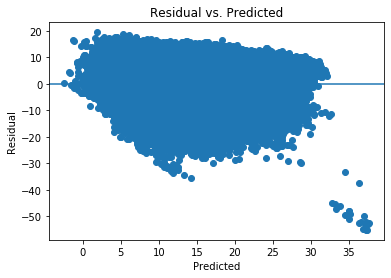

In [0]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

It seems that error variance is higher for the higher values of the target variable. This implies that our error terms aren't homoscedastic. However, deriving conclusions from visuals is only an informal way of figuring out the problem. Thankfully, there are several formal statistical tests that we can use to determine whether there is heteroscedasticity in the error terms.
Here, we demonstrate two of them: Bartlett and Levene tests. The null hypothesis for both tests is that the errors are homoscedastic. Both tests can be imported from scipy's stats module.

In [0]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The p values returned by the **bartlett and levene** method equals to 0 which is less than 0.05. We can reject the hypothesis and say that the error is **heteroscedastic**

### Assumption four: low multicollinearity

If there is correlation of 1 or -1 between a variable and another or several variables, this is called perfect multicollinearity. 
A remark on dummy variables: Caution is needed when working with dummy variables because of this linear combination issue. 

In [0]:
df.corr()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
temperature,1.000000,0.992629,-0.632255,0.008957,0.029988,0.392847,NaN,-0.005447
apparenttemperature,0.992629,1.000000,-0.602571,-0.056650,0.029031,0.381718,NaN,-0.000219
humidity,-0.632255,-0.602571,1.000000,-0.224951,0.000735,-0.369173,NaN,0.005454
windspeed,0.008957,-0.056650,-0.224951,1.000000,0.103822,0.100749,NaN,-0.049263
windbearing,0.029988,0.029031,0.000735,0.103822,1.000000,0.047594,NaN,-0.011651
visibility,0.392847,0.381718,-0.369173,0.100749,0.047594,1.000000,NaN,0.059818
loudcover,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pressure,-0.005447,-0.000219,0.005454,-0.049263,-0.011651,0.059818,NaN,1.000000


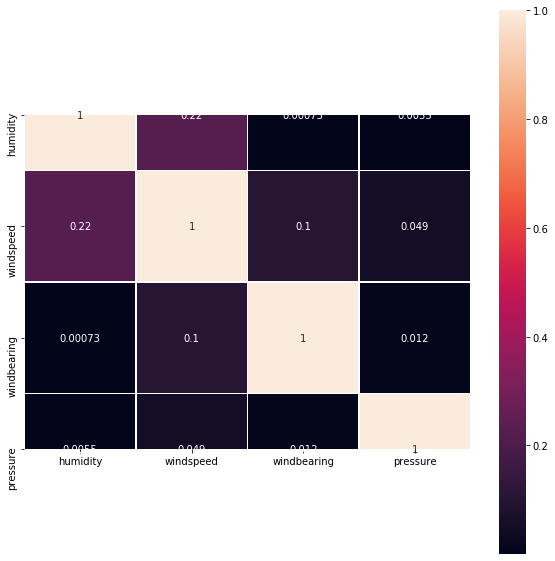

In [0]:
import seaborn as sns

corr_heatmap = np.abs(X.corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr_heatmap, square = True, annot=True, linewidth=.5)
plt.show()

### Assumption five: error terms should be uncorrelated with one another

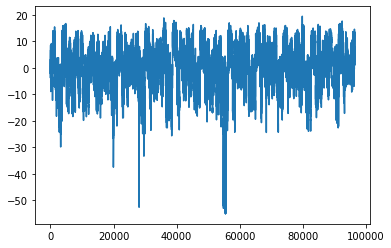

In [0]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

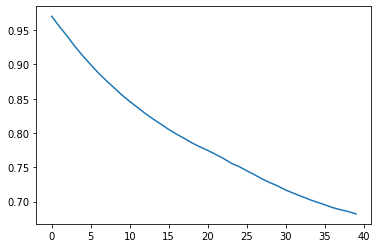

In [0]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

So, the autocorrelation between the errors of our Temperature model is high at the beginning nad slowly drops down. (ranging between 0.95 and 0.70).

### Assumption six: features shouldn't be correlated with the errors

#### Lets concat the features and the errors into a dataframe. This will help us picture the correlation of both.

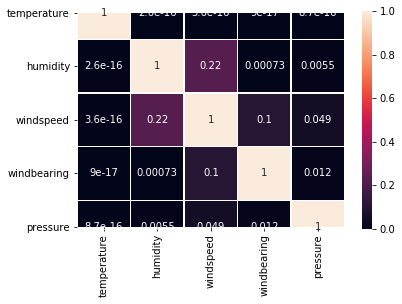

In [0]:
df_error_ft = pd.concat([errors, X], axis=1)

## Lets take the absolute value of it for better visualization

df_error_ft_abs = np.abs(df_error_ft.corr())
sns.heatmap(df_error_ft_abs, square = True, annot = True, linewidths =0.5)
plt.show()

The correlation coefficients aren't high and can be neglected. The assumption has been met.

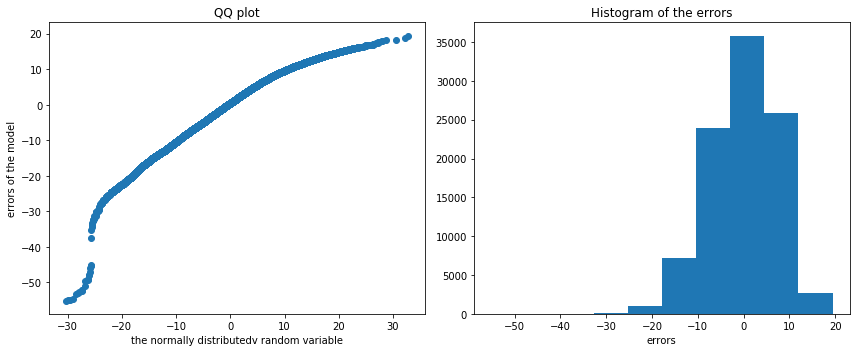

In [0]:
##There are various ways to check for normality of error terms. 
##An informal way of doing this is by visualizing the errors in a QQ plot or to look at the histogram:

rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributedv random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [0]:
##The plot seems almost normal but not 100 percent sure of it, 
##so let's get the statistical values with Jarque_bera and normal test.

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252366 and p value is 0.0
Normality test statistics is 3375.432307699586 and p value is 0.0


### The p values are less that 0.05, indicating the non-normality of the error.

## 2nd Dataset

# 2. House prices

To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:
Load the houseprices data from Thinkful's database.
Reimplement the model you built in the previous checkpoint.
Check for all of the assumptions above and discuss the implications if some of the assumptions are not met.
be sure to close the database connection after initially pulling in your data.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [0]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [0]:
house_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [0]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [0]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


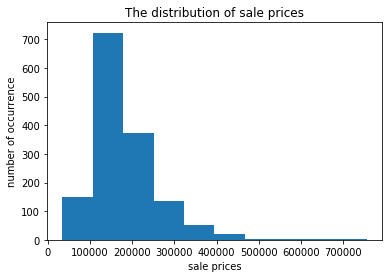

In [0]:
plt.hist(house_prices_df.saleprice)
plt.title("The distribution of sale prices")
plt.xlabel("sale prices")
plt.ylabel("number of occurrence")
plt.show()

### Lets get the absolute correlation value of all the numerical values and pick 5 features from them.



In [0]:
np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

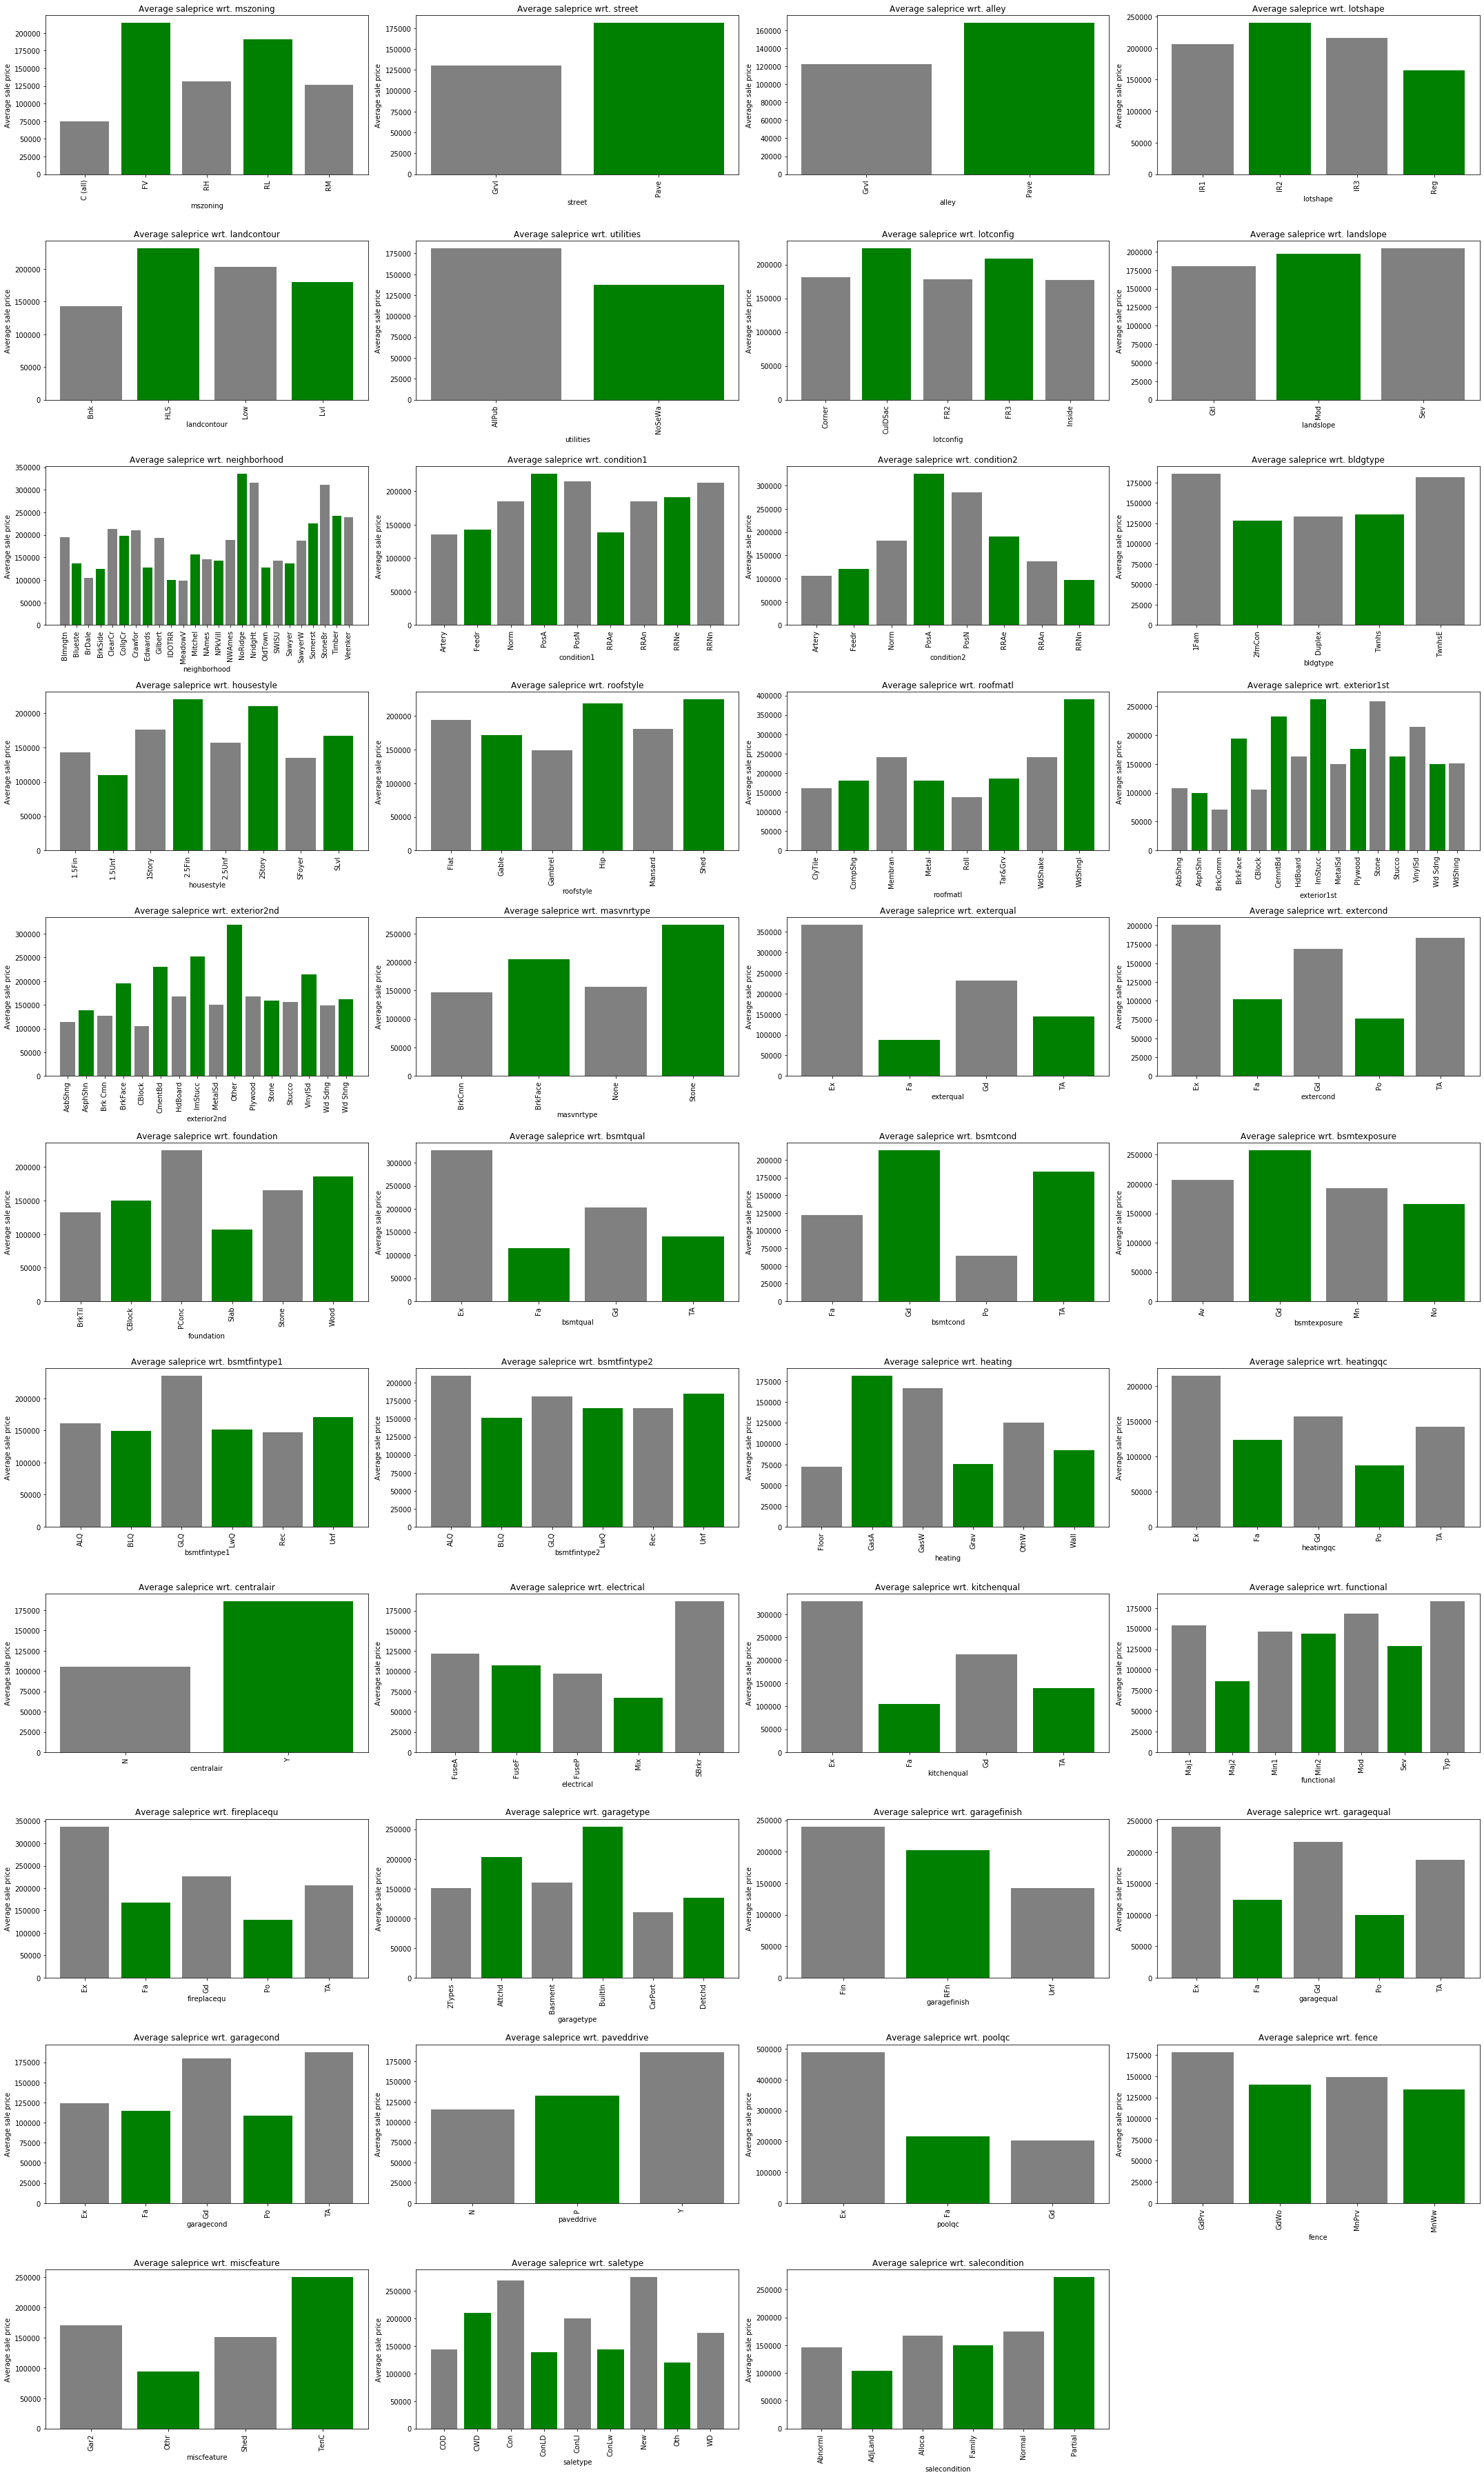

In [0]:
## Now for the non numeric variables, we will plot and take the 2 most corelated variables.

plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_prices_df.groupby(column)["saleprice"].mean().index, house_prices_df.groupby(column)["saleprice"].mean(),
           color=("grey","green"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [0]:
## Lets convert the non numeric variables to numbers 0 or 1 with get_dummies() function.

house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

### Now lets try out the assumptions.

In [0]:
from sklearn import linear_model
# Y is the target variable
Y = house_prices_df['saleprice']
# X is the feature set which includes
# humidity, windspeed, windbearing, and pressure. variables
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.33265353e+04 4.56343565e+01 1.34501364e+04 1.64082048e+01
 2.83816393e+01 2.50875137e+04 1.34204564e+04 2.85658560e+04
 9.04778936e+03 1.51037622e+02]

Intercept: 
 -117337.72871399301


In [0]:
## The term should be zero on average

predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -3.0957704588566744e-11


Returns a negative zero value, we can conclude it as a zero value. Hence, it is effective.

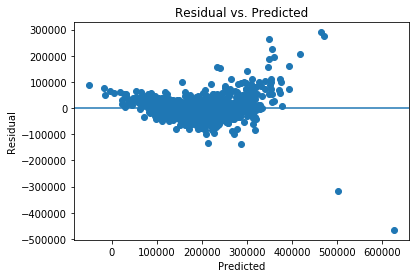

In [0]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#### The error variance is **CONSISTANT**, which gives us a sign that there is heteroscedasticity,  around the zero line but we do see few outliers that have high values at 500,000 predicted sale price

In [0]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


The p values of both the tests are lesser than 0.05, here we can reject the hypothesis and there is heteroscedasticity. 

### Assumption four: low multicollinearity

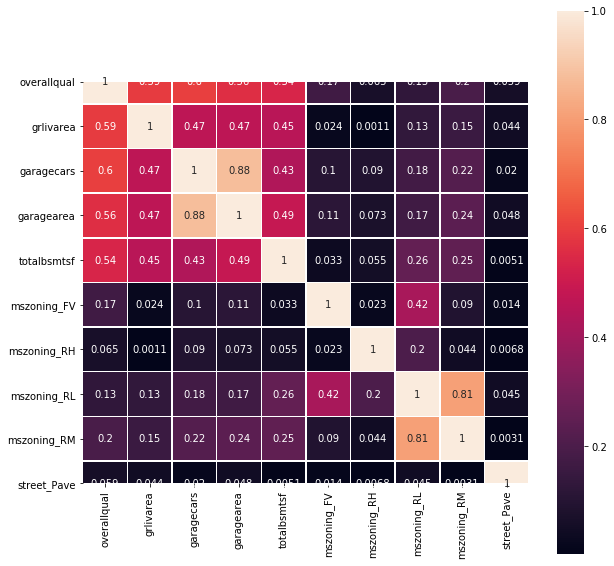

In [0]:
corr_heatmap = np.abs(X.corr())
plt.figure(figsize=(10,10))
sns.heatmap(corr_heatmap, square = True, annot=True, linewidth=.5)
plt.show()

few features do have significant correlations.

### Assumption five: error terms should be uncorrelated with one another

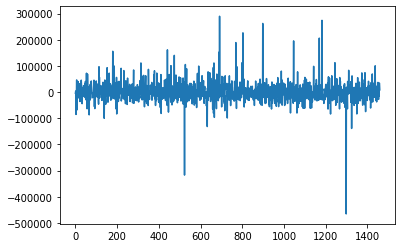

In [0]:
plt.plot(errors)
plt.show()

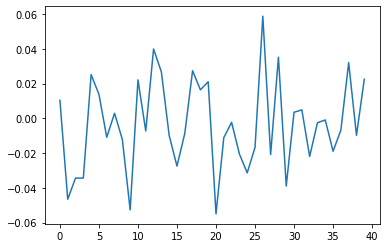

In [0]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The auto correlation of the houseprices are medium level correlated.

### Assumption six: features shouldn't be correlated with the errors

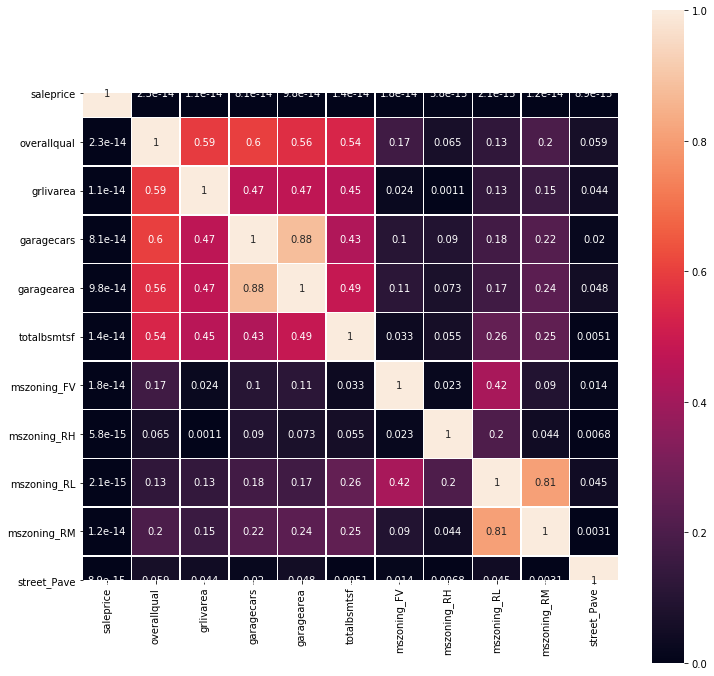

In [0]:
df_error_ft = pd.concat([errors, X], axis=1)

## Lets take the absolute value of it for better visualization
plt.figure(figsize=(12,12))
df_error_ft_abs = np.abs(df_error_ft.corr())
sns.heatmap(df_error_ft_abs, square = True, annot = True, linewidths =0.5)
plt.show()

There are few variables that does have high correlation for example grlivarea is highly correlate at 59% with overallqual 

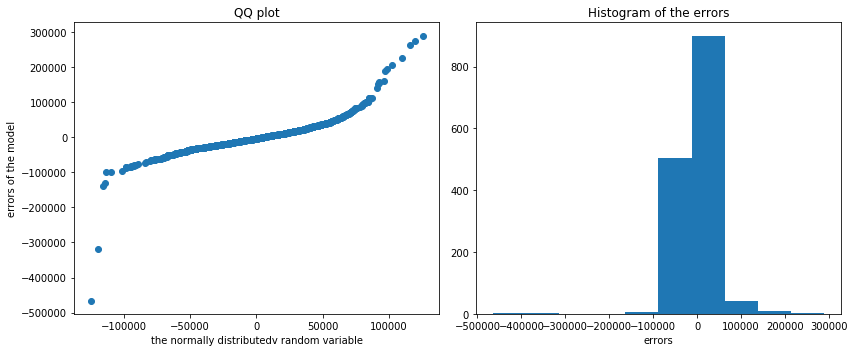

In [0]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributedv random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [0]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 41281.526018267796 and p value is 0.0
Normality test statistics is 415.8826568586338 and p value is 4.922984898056951e-91


The p values are lesser than 0.05 hence they are Not normally distributed.
